## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

In [22]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import nltk

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality-8k.csv",
     
    # model
   
    # chose tokenizer. possible values: "nst" and "sgt"
    ## NonStemmingTokenizer: 'nst'
    # - no stemming, only remove punctuation marks
    # - lowercase letters

    ## SimpleGermanTokenizer: 'sgt'
    # - remove punctuation marks
    # - stemming
    # - lowercase letters
    "tokenizer": "nst",
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier.json"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [24]:
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(config_dict['tokenizer'])

In [25]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

8007
8005
['SENTENCE', 'LOW_QUALITY', 'TITLE', 'REFERENCE', 'FOREIGN']


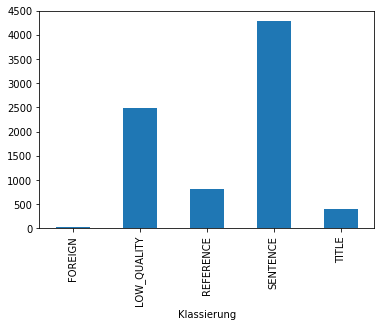

In [39]:
# set targets
print(len(data.index))
data = data.dropna(subset= ['Klassierung'])
print(len(data.index))
data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()
print(classes)

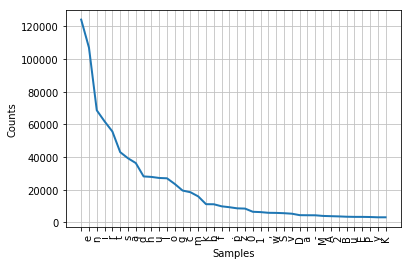

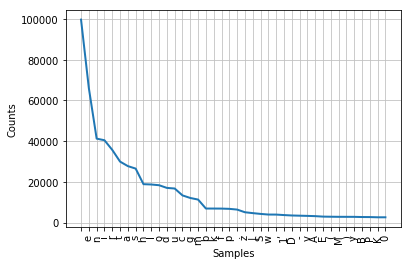

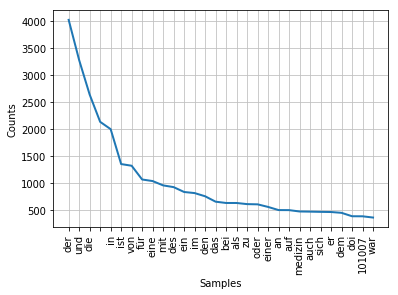

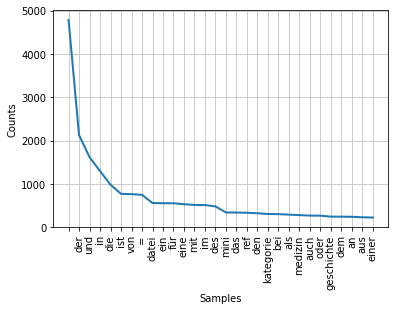

In [40]:
# character frequency analysis

high_quality = data.loc[data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]
low_quality = data.loc[[not a for a in data['Klassierung'].isin(['SENTENCE', 'REFERENCE'])]]

fdc = nltk.FreqDist()
tokens_h = []
for s in high_quality['Satz']:
    tokens_h.extend(tokenizer.tokenize(s))
    fdc.update(s)
    
# character frequencies
fdc.plot(40,cumulative=False)

tokens_l = []
fdc2 = nltk.FreqDist()
for s in low_quality['Satz']:
    tokens_l.extend(tokenizer.tokenize(s))
    fdc2.update(s)
    fdc.update(s)
    
# character frequencies
fdc2.plot(40,cumulative=False)

# word frequencies
fd = nltk.FreqDist(tokens_h)
fd.plot(30,cumulative=False) 
fd = nltk.FreqDist(tokens_l)
fd.plot(30,cumulative=False) 

In [41]:
# Keras LSTM input data

# one hot encoded characters
from keras.preprocessing.text import Tokenizer
tokenizer_char = Tokenizer(char_level=True)
tokenizer_char.fit_on_texts(data['Satz'])
char_int_encoded = tokenizer_char.texts_to_sequences(data['Satz'])

In [42]:
# set input data

import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=8, norm='l2', encoding='utf8', ngram_range=(2, 2), stop_words='english')
tfidf = tfidf.fit(data.Satz)

fd = nltk.FreqDist(tokens_h + tokens_l)

voc_chars = list(fdc.keys())[:200]
voc_words = list(fd.keys())[:500]

def convert_sentence_to_input(s):
    tokens = tokenizer.tokenize(s)
    fd_words = nltk.FreqDist(tokens)
    fd_chars = nltk.FreqDist(s)
    
    words = [fd_words.freq(w) for w in voc_words]
    chars = [fd_chars.freq(c) for c in voc_chars]
    
    words_in_vocab = sum(1 for i in words if i > 0.0)
    long_tail = float(words_in_vocab) /  len(tokens)
    
    tfidf_features = list(tfidf.transform([s]).toarray()[0])
    
    return np.array(words + chars + [long_tail/10.0], dtype=np.float32)

data['input'] = pd.Series([[convert_sentence_to_input(s)] for s in data['Satz']], index=data.index)
data.head()

,Satz,Tokens,Klassierung,Bemerkungen,label,input
0,Durch die Ausnutzung der Schwerkraft kann di...,"['durch', 'die', 'ausnutzung', 'der', 'schwerk...",SENTENCE,NaN,SENTENCE,"[[0.0384615, 0.0769231, 0.0384615, 0.0384615, ..."
1,Er ist vor allem mit seinen Arbeiten zum Thema...,"['er', 'ist', 'vor', 'allem', 'mit', 'seinen',...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0588235..."
2,An anderen [[Monoamin]]transportern wirken sie...,"['an', 'anderen', 'monoamin', 'transportern', ...",SENTENCE,NaN,SENTENCE,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,Etwa die Hälfte der an einem Schlaganfall-Erkr...,"['etwa', 'die', 'hälfte', 'der', 'an', 'einem'...",LOW_QUALITY,NaN,LOW_QUALITY,"[[0.0, 0.0294118, 0.0, 0.0294118, 0.0, 0.0, 0...."
4,Schwerpunktthema: Was ist gesichert in der The...,"['schwerpunktthema', 'was', 'ist', 'gesichert'...",TITLE,NaN,TITLE,"[[0.0, 0.0, 0.0, 0.142857, 0.0, 0.0, 0.0, 0.0,..."


In [43]:
# fit scikit learn models

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

models = [
    RandomForestClassifier(n_estimators=200, max_depth=4, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=8, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=16, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=32, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=64, random_state=0),
    RandomForestClassifier(n_estimators=200, max_depth=128, random_state=0),
    LinearSVC(),
    # MultinomialNB(),
    LogisticRegression(random_state=0),
    SVC(kernel='linear', gamma=2),
    # SVC(kernel='poly', gamma=2),
    SVC(kernel='rbf', gamma=2),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16), random_state=1),
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(32, 16, 8), random_state=1)
]

X_train, X_test, char_int_encoded_train, char_int_encoded_test, y_train, y_test = train_test_split(np.array([e[0] for e in data['input']]), char_int_encoded, data['label'], random_state = 2)

print(X_train.shape)

# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(X_train)
# tfidf_transformer = TfidfTransformer()
# X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [model.fit(X_train, y_train) for model in models]


(6003, 701)


RandomForestClassifier: 0.665334665335
RandomForestClassifier: 0.743256743257
RandomForestClassifier: 0.775724275724
RandomForestClassifier: 0.792707292707
RandomForestClassifier: 0.789210789211
RandomForestClassifier: 0.79020979021
LinearSVC: 0.733266733267
LogisticRegression: 0.656343656344
SVC: 0.682317682318
SVC: 0.732267732268
MLPClassifier: 0.762737262737
MLPClassifier: 0.746753246753
MLPClassifier: 0.754245754246
MLPClassifier: 0.742257742258
MLPClassifier: 0.729270729271


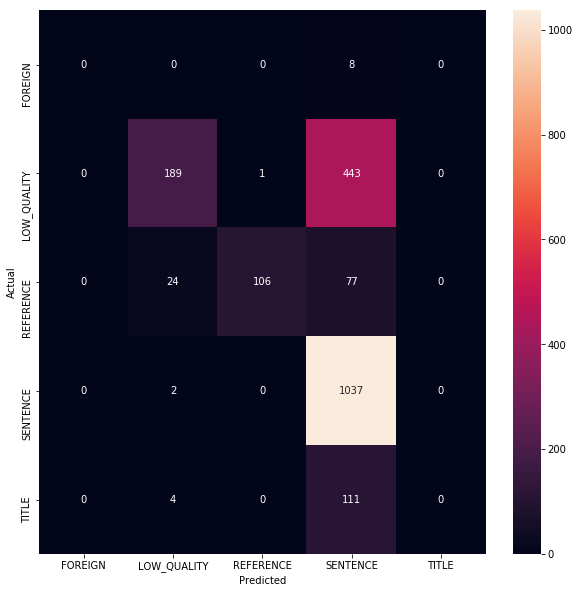

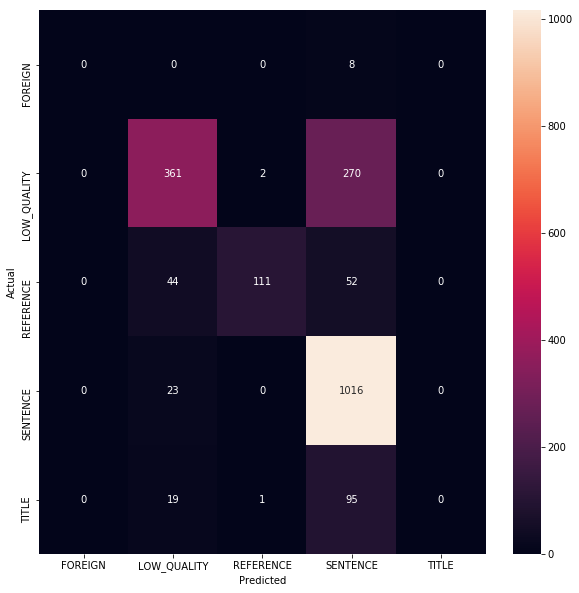

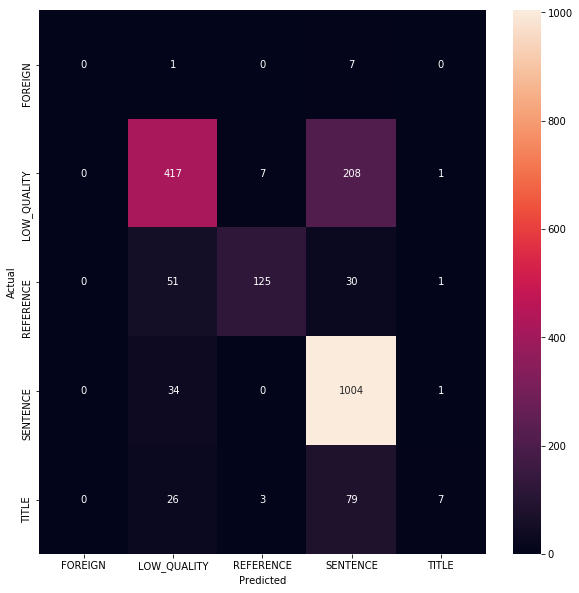

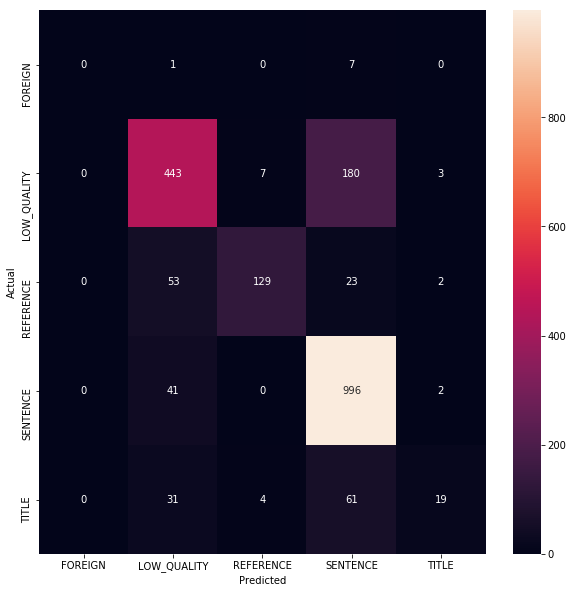

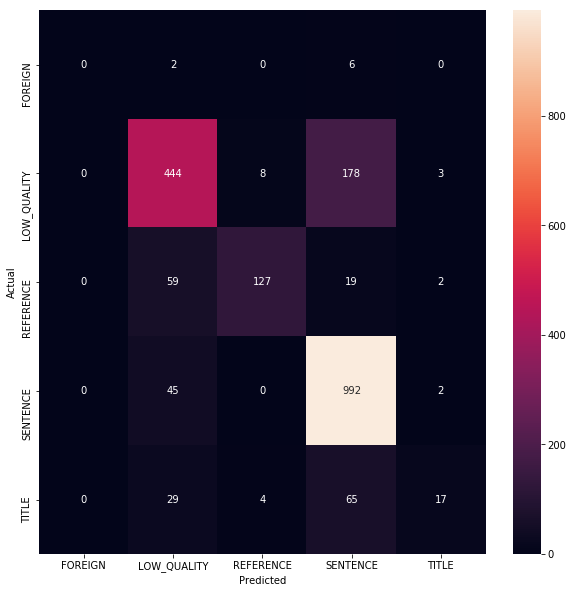

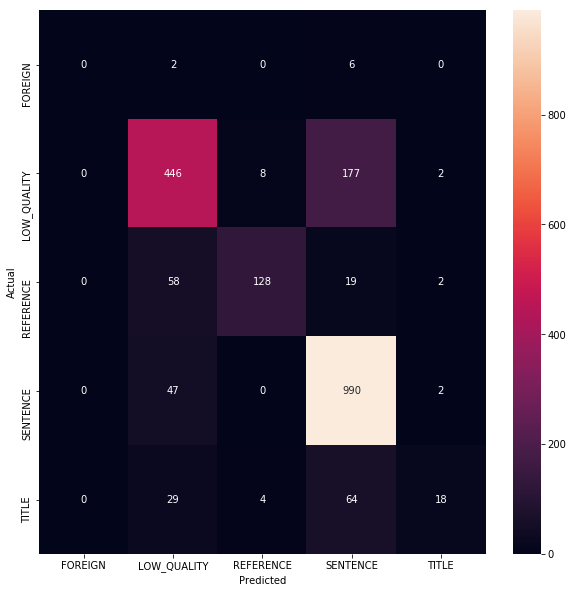

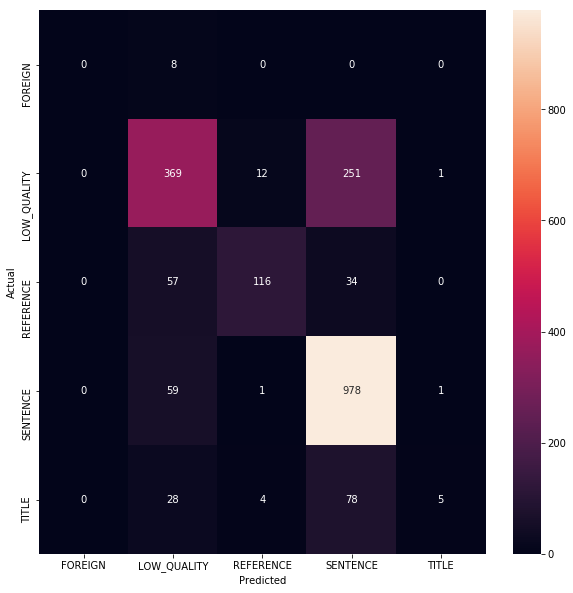

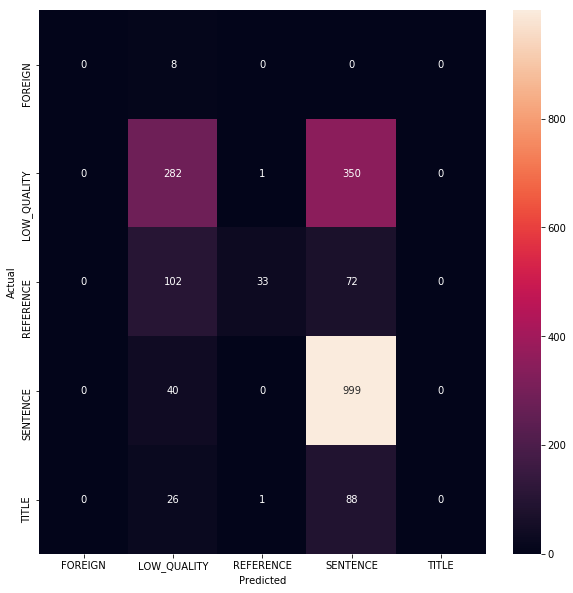

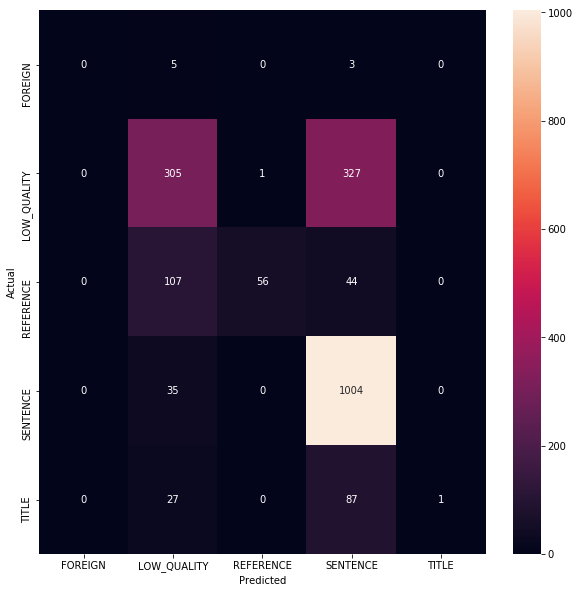

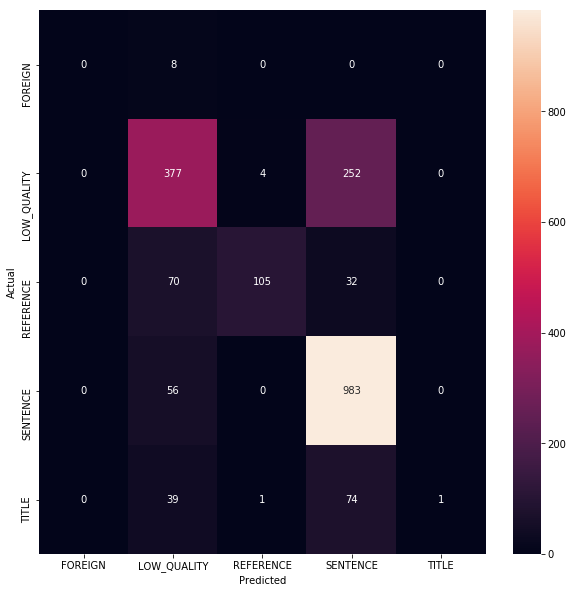

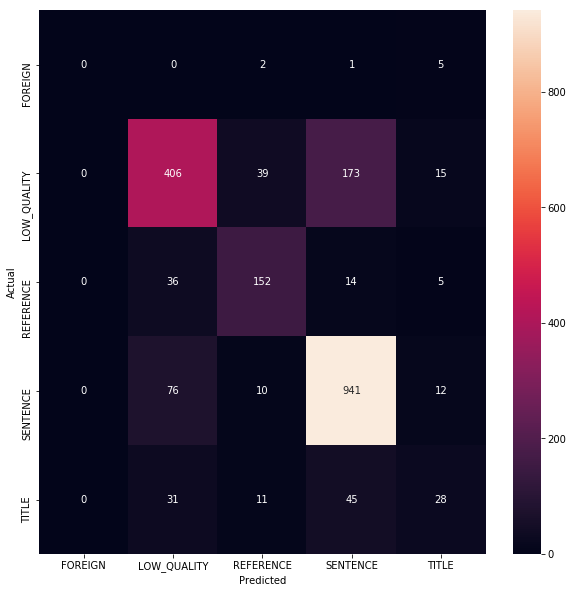

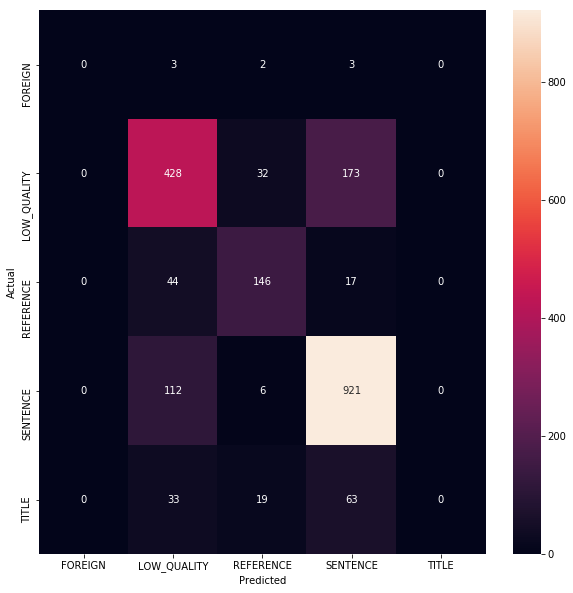

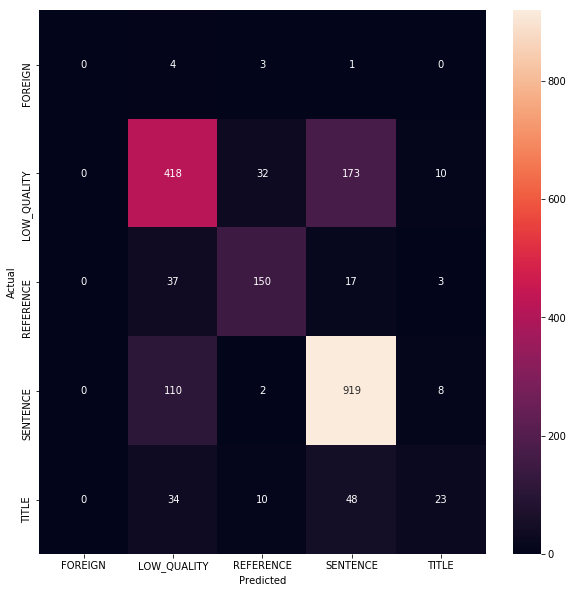

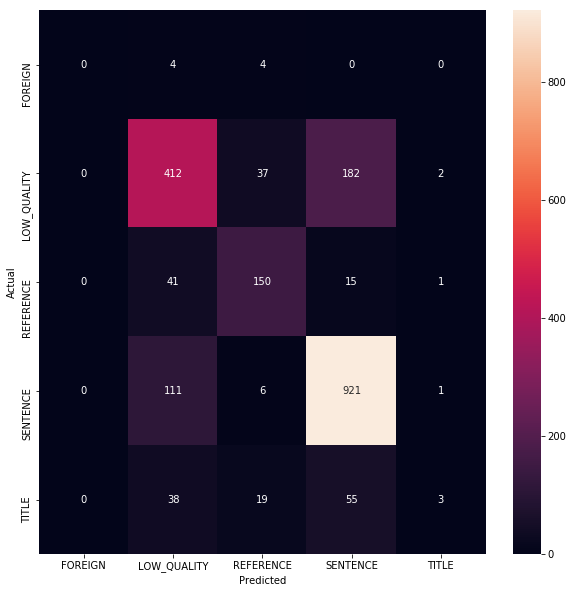

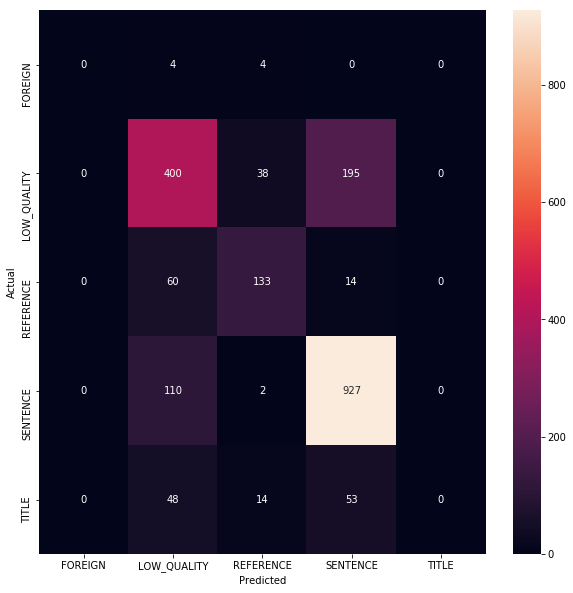

In [44]:
# model evaluation

for model in models:
    y_pred = model.predict(X_test)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score

    print(model.__class__.__name__ + ": " + str(accuracy_score(y_test, y_pred)))

    conf_mat = confusion_matrix(y_test, y_pred)

    import matplotlib.pyplot as plt
    import seaborn as sns

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # plt.show()

In [45]:
# Keras MLP
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

batch_size = 128
num_classes = len(classes)
epochs = 1000


# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_test = np_utils.to_categorical(encoded_y_test)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

# early stopping criterion
early_stopping = EarlyStopping(monitor='val_acc', patience=20)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, dummy_y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, dummy_y_test),
                    callbacks=[early_stopping])
score = model.evaluate(X_test, dummy_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               89856     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 90,501
Trainable params: 90,501
Non-trainable params: 0
_________________________________________________________________
Train on 6003 samples, validate on 2002 samples
Epoch 1/1000
6003/6003 [==============================] - 0s - loss: 1.2974 - acc: 0.5332 - val_loss: 1.1266 - val_acc: 0.5195
Epoch 2/1000
6003/6003 [==============================] - 0s - loss: 1.0379 - acc: 0.5579 - val_loss: 1.0213 - val_acc: 0.5509
Epoch 3/1000
6003/6003 [==============================] - 0s - loss: 0.9490 - acc: 0.5994 - val_loss

6003/6003 [==============================] - 0s - loss: 0.4666 - acc: 0.8213 - val_loss: 0.6041 - val_acc: 0.7702
Epoch 60/1000
6003/6003 [==============================] - 0s - loss: 0.4670 - acc: 0.8204 - val_loss: 0.6093 - val_acc: 0.7617
Epoch 61/1000
6003/6003 [==============================] - 0s - loss: 0.4643 - acc: 0.8214 - val_loss: 0.6045 - val_acc: 0.7732
Epoch 62/1000
6003/6003 [==============================] - 0s - loss: 0.4623 - acc: 0.8204 - val_loss: 0.6027 - val_acc: 0.7702
Epoch 63/1000
6003/6003 [==============================] - 0s - loss: 0.4600 - acc: 0.8263 - val_loss: 0.6030 - val_acc: 0.7717
Epoch 64/1000
6003/6003 [==============================] - 0s - loss: 0.4590 - acc: 0.8254 - val_loss: 0.6050 - val_acc: 0.7692
Epoch 65/1000
6003/6003 [==============================] - 0s - loss: 0.4576 - acc: 0.8241 - val_loss: 0.6046 - val_acc: 0.7682
Epoch 66/1000
6003/6003 [==============================] - 0s - loss: 0.4582 - acc: 0.8219 - val_loss: 0.6054 - val_ac

6003/6003 [==============================] - 0s - loss: 0.3862 - acc: 0.8577 - val_loss: 0.6289 - val_acc: 0.7752
Epoch 123/1000
6003/6003 [==============================] - 0s - loss: 0.3880 - acc: 0.8506 - val_loss: 0.6272 - val_acc: 0.7742
Epoch 124/1000
6003/6003 [==============================] - 0s - loss: 0.3839 - acc: 0.8546 - val_loss: 0.6328 - val_acc: 0.7672
Epoch 125/1000
6003/6003 [==============================] - 0s - loss: 0.3866 - acc: 0.8549 - val_loss: 0.6363 - val_acc: 0.7682
Epoch 126/1000
6003/6003 [==============================] - 0s - loss: 0.3853 - acc: 0.8556 - val_loss: 0.6301 - val_acc: 0.7777
Test loss: 0.630098594831
Test accuracy: 0.777722277544


In [12]:
# Keras GRU

from keras.models import Sequential
from keras.layers import *
n_symbols = len(tokenizer_char.word_index) + 1
seq_length = 64
embedding_size = 20
batch_size = 32

char_int_encoded_train = keras.preprocessing.sequence.pad_sequences(
            char_int_encoded_train, maxlen=seq_length, dtype='int', truncating='pre')
char_int_encoded_test = keras.preprocessing.sequence.pad_sequences(
            char_int_encoded_test, maxlen=seq_length, dtype='int', truncating='pre')

model = Sequential()
model.add(Embedding(input_dim=n_symbols,
                          output_dim=n_symbols,
                          input_length=seq_length,
                          mask_zero=False, embeddings_initializer='identity', trainable=False))
model.add(GRU(32, dropout=0.0, recurrent_dropout=0.0))
model.add(Dense(16, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

history = model.fit(char_int_encoded_train, encoded_y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(char_int_encoded_test, encoded_y_test),
                    callbacks=[early_stopping])
score = model.evaluate(char_int_encoded_test, encoded_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 64, 294)           86436     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                31392     
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
Total params: 118,356
Trainable params: 31,920
Non-trainable params: 86,436
_________________________________________________________________
Train on 3003 samples, validate on 1001 samples
Epoch 1/1000
3003/3003 [==============================] - 3s - loss: 1.8205 - acc: 0.4276 - val_loss: 1.1439 - val_acc: 0.5075
Epoch 2/1000
3003/3003 [==============================] - 3s - loss: 1.1391 - acc: 0.5135 - val_loss: 1.1232 - val_acc: 0.5075
Epoch 3/1000
3003/3003 [==============================] - 3s - loss: 1.1234 - acc: 0.5198 - va